# Meteo 515 – Assignment 1 – Exploratory Data Analysis
*Part 2 – examining the NAO and AMO distributions*

In [1]:
from __future__ import division
from collections import OrderedDict
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
#from sklearn.neighbors import KernelDensity
#import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_acf, _plot_corr
from statsmodels.nonparametric.kde import KDEUnivariate
#from statsmodels.robust.scale import mad

from hw1p2_utils import load_data, make_table

In [2]:
# for some interactions with figures, and sizes closer to the usual sizes
%matplotlib notebook

## Load data and do some processing
Code for loading the data is found in separate file, 'hwp1p2_utils.py', as well as the code for the summary stats and making the table. Or, see the hw1p1 notebook for details of the latter two. 

### Processing
After loading the data and selected a common time period of interest (here 1900–2015), we normalize/standardize, as in $z = \frac{x-\bar{x}}{s_x}$. Note that the NAO data we are using for this assignment has already been normalized once. The AMO data has not.

In [3]:
nao, amo_us = load_data()

#> select time period
#  is assigning a .loc different from dropping in place? (i.e. is the Series copied, using memory?)
ya = dt.datetime(1900, 1, 1)
yb = dt.datetime(2015, 12, 31)
nao = nao.loc[(nao.index >= ya) & (nao.index <= yb)]
amo_us = amo_us.loc[(amo_us.index >= ya) & (amo_us.index <= yb)]

#> normalizing
nao_bar = np.nanmean(nao)
s_nao = np.nanstd(nao)
nao_rn = (nao - nao_bar) / s_nao  # rn for re-normlized

amo_us_bar = np.nanmean(amo_us)
s_amo_us = np.nanstd(amo_us)
amo_us_n = (amo_us - amo_us_bar) / s_amo_us  # n for normalized

## a) Summary stats

In [4]:
stats = make_table([nao_rn, amo_us_n], ['NAO', 'AMO'])

          mean   median   std     IQR     MAD   skewness  Y-K   
  NAO     -0.000  -0.012   1.000   1.393   0.699   0.079   0.003
  AMO      0.000  -0.024   1.000   1.496   0.747   0.087   0.032


We can see that our normalization was effective: in the summary stats, both our NAO and AMO have mean=0 and std=1, properties of the standard normal distribution. The higher IQR and MAD tell us that the AMO distribution is a little bit wider. It is also more strongly skewed than the NAO.

## b) Time series plots

<IPython.core.display.Javascript object>


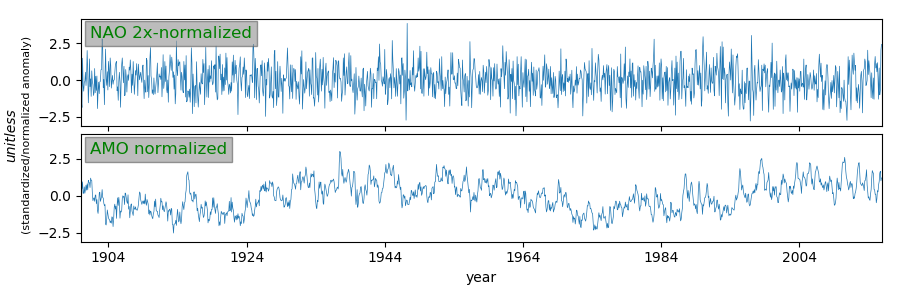

In [5]:
f1, [a1, a2] = plt.subplots(2, 1, figsize=(9, 3), sharex=True, sharey=True, num='ts')

#> some settings for both plots
a1.set_xlim( (mdates.date2num(nao.index[0]), mdates.date2num(nao.index[-1])) ) 
lw = 0.5
txtbboxprops = dict(boxstyle='square',
                    facecolor='0.6', edgecolor='0.4', alpha=0.65, 
                    )
txtcolor = 'g'
txtsize = 12

a1.plot(nao_rn, lw=lw)

#> find good spot for txt
#  note: could really use `transform=ax.transAxes` for this instead
xlim, ylim = a1.get_xlim(), a1.get_ylim()
xtxt = xlim[0] + (xlim[-1]-xlim[0])*0.011
ytxt = ylim[0] + (ylim[-1]-ylim[0])*0.93

#s = 'NAO \small{2x-normalized}'  # pdf saved with tex text has spacing issues, for the fig.text and too much right padding in the text bbox
s = 'NAO 2x-normalized'
a1.text(xtxt, ytxt, s, #usetex=True,
        color=txtcolor, size=txtsize, va='top', ha='left',
        bbox=txtbboxprops)
#a1.set_ylabel('unitless', style='italic')

a2.plot(amo_us_n, lw=lw)
a2.set_xlabel('year')

#s = 'AMO \small{normalized}'
s = 'AMO normalized'
a2.text(xtxt, ytxt, s, #usetex=True,
        color=txtcolor, size=txtsize, va='top', ha='left', 
        bbox=txtbboxprops)

f1.text(0.012, 0.55, 'unitless', 
        ha='center', va='center', rotation='vertical', style='italic')
f1.text(0.03, 0.55, '(standardized/normalized anomaly)', 
        ha='center', va='center', rotation='vertical', size=8)

f1.tight_layout(h_pad=0.10, rect=[0.025, 0, 1.0, 1.0])

We can see in the time series plots above that the NAO has stronger high-frequency signals, whereas the AMO is dominated by relatively lower frequency cycles, perhaps $\sim$ 10 years.  

## c) Histograms and KDEs

<IPython.core.display.Javascript object>


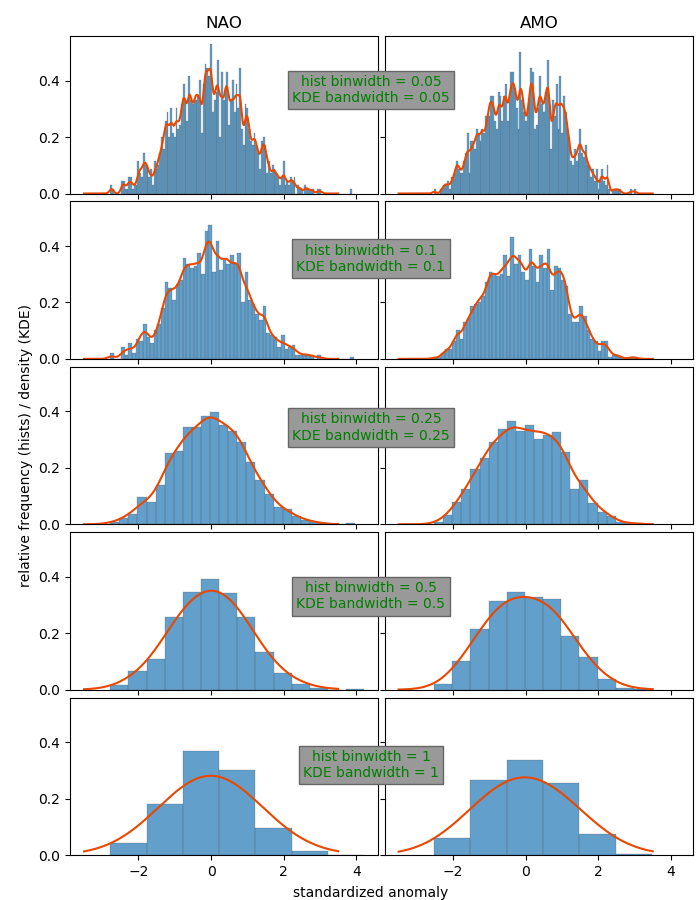

Text(0.53,0,'standardized anomaly')

In [6]:
#> some pre-calculations
nao_rn_size = nao_rn.size
nao_rn_min = nao_rn.min()
nao_rn_max = nao_rn.max()
amo_us_n_size = amo_us_n.size
amo_us_n_min = amo_us_n.min()
amo_us_n_max = amo_us_n.max()

kd_bandwidths  = [0.05, 0.1, 0.25, 0.5, 1.0]
x_kde = np.linspace(-3.5, 3.5, 1000)
kde_color = '#ea4800'  # '#ea3c00', 'orange'
kde_lw = 1.5

hist_binwidths = kd_bandwidths#[0.05, 0.1, 0.5, 1, 2]

f2, aa = plt.subplots(len(kd_bandwidths), 2, 
                      figsize=(7.0, 9.0), sharex=True, sharey=True, num='hists-and-kd',
                      gridspec_kw=dict(hspace=0.05, wspace=0.02, left=0.1, bottom=0.05, top=0.96, right=0.99), 
                      )  # ^ tight_layout h and w_pad not working anymore for some reason...

txtbboxprops2 = txtbboxprops
txtbboxprops2.update({'alpha': 1.0})  # for overlaying in between subplots

for i, (a1, a2) in enumerate(aa):
    
    kd_bw = kd_bandwidths[i]
    h_bw = hist_binwidths[i]
    
    h_bins_nao = np.arange(nao_rn_min, nao_rn_max+h_bw, h_bw)
    a1.hist(nao_rn, bins=h_bins_nao, density=True,
            alpha=0.7, ec='0.35', lw=0.25)
    
    #> NAO. using sklearn
#    kde = KernelDensity(kernel='gaussian', bandwidth=kd_bw).fit(nao_rn)
#    log_dens = kde.score_samples(x_kde)
#    a1.plot(x_kde, np.exp(log_dens), 'r-')
    
    #> NAO. using StatsModels
    kde = KDEUnivariate(nao_rn)
    kde.fit(bw=kd_bw)
    a1.plot(x_kde, kde.evaluate(x_kde), '-', color=kde_color, lw=kde_lw)
    
    h_bins_amo = np.arange(amo_us_n_min, amo_us_n_max+h_bw, h_bw)
    a2.hist(amo_us_n, bins=h_bins_amo, density=True,
            alpha=0.7, ec='0.35', lw=0.25)

    #> AMO. using StatsModels
    kde = KDEUnivariate(amo_us_n)
    kde.fit(bw=kd_bw)
    a2.plot(x_kde, kde.evaluate(x_kde), '-', color=kde_color, lw=kde_lw)


#> label things
aa[0,0].set_title('NAO')
aa[0,1].set_title('AMO')

ytxts = np.linspace(0.15, 0.9, len(kd_bandwidths))[::-1]
for i, (kd_bw, h_bw) in enumerate(zip(kd_bandwidths, hist_binwidths)):
    
    s = 'hist binwidth = {:g}\nKDE bandwidth = {:g}'.format(h_bw, kd_bw)
    f2.text(0.53, ytxts[i], s,
        color=txtcolor, size=10, va='center', ha='center',
        bbox=txtbboxprops2)


#f2.text(0.015, 0.55, 'relative frequency', #usetex=True, 
#        ha='center', va='center', rotation='vertical')

aa[2,0].set_ylabel('relative frequency (hists) / density (KDE)')

f2.text(0.53, 0.0, 'standardized anomaly',  # don't understand why the notebook prints this out...
        ha='center', va='bottom')
        
#f2.tight_layout(h_pad=0.05, w_pad=0.05, rect=[0.0, 0.006, 1.0, 1.0])
#f2.tight_layout(h_pad=0.05, w_pad=0.05)

Picking identical histogram binwidth and KDE bandwidth gives similar representations of the distribution shape. We can see in the above figure that after about a binwidth of 0.25, or around 20 bins, all of the complex features we see in binwidth 0.05 have been smeared out. If I had to pick the best representation of the data (keeping in mind the value of $N$, and with the goal of visually probing the true distribution), I would pick binwidth somewhere between 0.1 and 0.25. 

## d) Autocorrelation

<IPython.core.display.Javascript object>


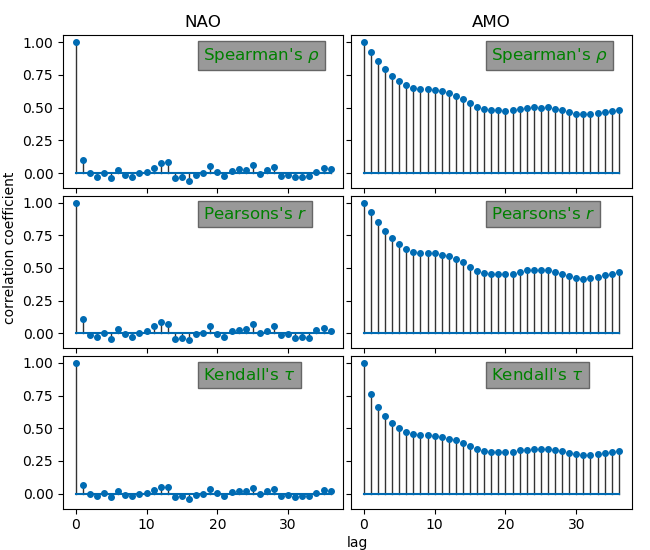

In [9]:
ilags = np.arange(0, 36+1, 1)  # note that autocorr is a symmetrical problem

def calc_acorr(x, ilags=ilags, corr_method='Pearson'):
    """Calculate autocorrelation for certain corr method
    Subsets the input x vector to do so
    Though since we have extra data outside the bounds we could use it instead...
    """
    x = np.array(x)
    
    fns = {'Pearson': ss.pearsonr, 
           'KT': ss.kendalltau,
           'Spearman': ss.spearmanr}
    
    try: 
        f = fns[corr_method]
    
    except KeyError:
        print('not supported')
        return
    
    acorr = np.zeros(ilags.shape)
    for j, ilag in enumerate(ilags):
        
        if ilag > 0:
            x0 = x[:-ilag]
            y = x[ilag:]
        else:
            x0 = x
            y = x
        
        acorr[j] = f(x0, y)[0]
    
    return acorr
    

indices = {'NAO': nao_rn, 'AMO': amo_us_n}
corr_methods = {'Pearson': "Pearsons's $r$", 
                'KT': r"Kendall's $\tau$", 
                'Spearman': r"Spearman's $\rho$"}

f3, aa = plt.subplots(len(corr_methods), len(indices),
                      figsize=(6.5, 5.5), sharex=True, sharey=True, num='auto-corr')

xtxt = ilags.mean()
ytxt = 0.97

for i, corr_method in enumerate(corr_methods):
    rowaa = aa[i]
    
    for j, indexname in enumerate(indices):
        ax = rowaa[j]
        
        if j == 0:
            assert(indexname == 'NAO')  # for title..
        
        data = indices[indexname]
        
        acorr = calc_acorr(data, corr_method=corr_method)
        
        markers, stemlines, baseline = ax.stem(acorr)
        plt.setp(markers,   color='#006bb3', ms=4, zorder=2)
        plt.setp(stemlines, color='0.2', linewidth=1.0, zorder=1)
        plt.setp(baseline,  color='#006bb3', linewidth=1.5, zorder=1)
                 
#        ax.fill_between(  color='#99d6ff')  # for confidence interval...
        
        s = corr_methods[corr_method]
#        s = indexname + '\n' + r'\small{{{}}}'.format(corr_methods[corr_method])
        ax.text(xtxt, ytxt, s, #usetex=True,
            color=txtcolor, size=12, va='top', ha='left',
            bbox=txtbboxprops)

aa[0,0].set_title('NAO')
aa[0,1].set_title('AMO')

f3.text(0.015, 0.55, 'correlation coefficient', #usetex=True, 
        ha='center', va='center', rotation='vertical')

f3.text(0.55, 0.0, 'lag', #usetex=True, 
        ha='center', va='bottom')
        
f3.tight_layout(h_pad=0.05, w_pad=0.05, rect=[0.025, 0.005, 1.0, 1.0])

Examining the autocorrelation plots above, we find:

* NAO has higher frequency signals in the plot, but overall has much weaker autocorrelation than AMO
* In both, Kendall's $\tau$ gives weakest autocorrelation, and Spearman's $\rho$ the strongest, although the Spearman and Pearson results are very similar

Since Spearman and Pearson results are pretty similar, we can deduce (because we know that Pearson is neither robust nor resistant but Spearman is both) that the detected relationship is close to linear and outliers are not a big problem. The lower value of Kendall indicates the presence of random noise, which the Kendall method is more sensitive to compared to the others. 

In [8]:
#> save figs
for n in plt.get_fignums():
    f = plt.figure(n)
    f.savefig('./figs/hw1p2_{:s}.pdf'.format(f.get_label()),
        transparent=True, 
        bbox_inches='tight', pad_inches=0.05,
        )